# Machine learning: prediction

Machine learning-trained algorithms can be used to predict the identity of sounds in recordings. For instance, an algorithm trained how to detect the sound of a Wood Thrush can be used to figure out where Wood Thrushes vocalize in a set of autonomous recordings. 

The Kitzes Lab, the developers of OpenSoundscape, pre-trained a series of [baseline machine learning models](https://pitt.box.com/s/a6jeamnew098vp5a9a7m1h9j5rce6t6y) that can be used to predict the presence of [506 species of common North American birds](https://pitt.app.box.com/s/d0snd1tyilscksbxc36q2slz6s4aa2ag). These are our "beta" models and are for demonstration purposes only, not for research use. We hope to make our more accurate models available soon. 

If you are interested in using these machine learning models for research, please contact us at the [Kitzes Lab](https://kitzeslab.org).

This tutorial downloads an example model and demonstrates how to use it to predict the identity of birds in recordings. To download the tutorial as a Jupyter Notebook and run it on your own computer, click the "Edit on GitHub" button at the top right of the tutorial. You will have to [install OpenSoundscape](installation.html#installation) to use the tutorial.

### Import modules
Import the following modules to run a pre-trained machine learning learning classifier. First, from OpenSoundscape we will need two classes (`Audio` and `SingleTargetAudioDataset`) and three functions (`run_command`, `lowercase_annotations`, and `predict`).

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.datasets import SingleTargetAudioDataset
from opensoundscape.helpers import run_command
from opensoundscape.raven import lowercase_annotations
from opensoundscape.torch.predict import predict

Import the following machine learning-related modules. OpenSoundscape uses PyTorch to do machine learning.

In [2]:
import torch
import torch.nn
import torchvision.models
import torch.utils.data
import torchvision.transforms

Lastly, use a few miscellaneous functions.

In [3]:
import yaml
import os.path
import pandas as pd
from pathlib import Path
from math import floor

## Prepare model

To use the model, it must be downloaded onto your computer and loaded with the same specifications it was created with.

### Download model
Download the example model for Wood Thrush, *Hylocichla mustelina*. First, create a folder called `"prediction_example"` to store the model and its data in.

In [4]:
folder_name = "prediction_example"
folder_path = Path(folder_name)
if not folder_path.exists(): folder_path.mkdir()

Next, download the model from the Box storage site using the following lines. If you prefer, you can also download the model off of [this](https://pitt.app.box.com/s/dslgslmag7y8ojqxv28mwhbnt7irpgeo) webpage. Make sure to move it into the `"prediction_example"` folder and ensure that it is named `"hylocichla-mustelina-epoch-4.model"`.

In [5]:
def download_from_box(link, name):
    run_command(f"curl -L {link} -o ./{name}")

In [6]:
model_filename = folder_path.joinpath("hylocichla-mustelina-epoch-4.model")
download_from_box(
    link = "https://pitt.box.com/shared/static/dslgslmag7y8ojqxv28mwhbnt7irpgeo.model",
    name = model_filename
)

Make sure that the model was downloaded correctly.

In [7]:
assert(model_filename.exists())

### Load model
At its core, a machine learning model consists of two things: its architecture and its weights. 

The architecture is the complex structure of the model, which in this case, is a convolutional neural network. Convolutional neural networks are a particular set of algorithms especially suited to extracting and interpreting features from images, such as combinations of lines, dots, and edges. In this case, we use a `resnet18` convolutional neural network. After feature extraction, the convolutional neural network's features are passed to a classifier. The classifier decides how to weight each feature in predicting the final class identity. The model was trained with a `Linear` classifier.

Create the architecture of the model. First, designate the model as a `resnet18` CNN.

In [8]:
model = torchvision.models.resnet18(pretrained=False)

Then, add the `fc` layers. "FC" stands for "fully connected". To set up the proper architecture, we need to specify the correct number of input features, output features, and classifier type. 

The number of input features to the FC is equal to the number of features extracted from the convolutional neural network and passed to the the FC layer: `model.fc.in_features`

In [9]:
num_cnn_features = model.fc.in_features

The models were trained to predict two classes (species present and species absent), so the number of output features of the FC layer is 2.

In [10]:
num_classes = 2

Finally, the classifier type is a `torch.nn.Linear` classifier.

In [11]:
model.fc = torch.nn.Linear(
    in_features = num_cnn_features,
    out_features = num_classes)

The weights of the model are distinguished from its architecture because, while the architecture is decided by humans, the weights of the architecture are learned during the machine learning process. When downloading the machine learning model, you downloaded the weights. 

First, use `torch.load` to get the model weights from the filename.

In [12]:
weights = torch.load(model_filename)

Now, load the weights into the architecture we have created. After this the model is almost ready to use.

In [13]:
model.load_state_dict(weights)

<All keys matched successfully>

## Prepare prediction files

To actually use the model, we need to download and prepare a set of recordings. The model was trained to make predictions on spectrograms made from 5 second-long recordings, so we will have to split the recordings up and transform them into spectrograms.

### Download data
As example data, we have provided a 1 minute-long soundscape which contains Wood Thrush vocalizations. 

The following code downloads this audio file into the `"prediction_example"` folder created above. If you prefer, you can also download this file at [this link](https://pitt.box.com/shared/z73eked7quh1t2pp93axzrrpq6wwydx0). Make sure to move it into the `"prediction_example"` folder and ensure that it is named `"1min.wav"`.

In [14]:
data_filename = folder_path.joinpath("1min.wav")
download_from_box(
    link = "https://pitt.box.com/shared/static/z73eked7quh1t2pp93axzrrpq6wwydx0.wav",
    name = data_filename
)

### Split data
The example soundscape must be split up into soundscapes of the same size as the ones the model was trained on. In this case, the soundscapes should be 5s long.

First, create a directory in which to save split files.

In [15]:
split_directory = folder_path.joinpath("split_files")
if not split_directory.exists(): split_directory.mkdir()

Next, load the 1-minute long file as an `Audio` object.

In [16]:
base_file = Audio.from_file(data_filename)

Every split file will be saved with a prefix and the start and end times of the split with respect to the original file. In this case, let's make the prefix equal to the filename of the base file, without the extension (its stem):

In [17]:
split_prefix = data_filename.stem
split_prefix

'1min'

`Audio` objects have the method `split_and_save()` which allows you to split the recording in the audio object into segments of the specified length. Here, we split the clips into a 5s length, specify the directory they should be saved in (the `split_directory` just created) and specify the prefix of the file.

In [18]:
split_files = base_file.split_and_save(
    clip_length=5,
    destination=split_directory,
    name=split_prefix
)

The output of this function, `split_files`, is a dataframe which identifies the filename of each split and its start and end times:

In [19]:
split_files

,start_time,end_time
file,,
1min_0s-5s.wav,0,5
1min_5s-10s.wav,5,10
1min_10s-15s.wav,10,15
1min_15s-20s.wav,15,20
1min_20s-25s.wav,20,25
1min_25s-30s.wav,25,30
1min_30s-35s.wav,30,35
1min_35s-40s.wav,35,40
1min_40s-45s.wav,40,45


Prepend the "file" index with the directory in which the files are found so that the computer can refer to the files:

In [20]:
split_files['file_path'] = [split_directory.joinpath(split_file) for split_file in split_files.index]

In [21]:
split_files.head()

,start_time,end_time,file_path
file,,,
1min_0s-5s.wav,0,5,prediction_example/split_files/1min_0s-5s.wav
1min_5s-10s.wav,5,10,prediction_example/split_files/1min_5s-10s.wav
1min_10s-15s.wav,10,15,prediction_example/split_files/1min_10s-15s.wav
1min_15s-20s.wav,15,20,prediction_example/split_files/1min_15s-20s.wav
1min_20s-25s.wav,20,25,prediction_example/split_files/1min_20s-25s.wav


### Create a Dataset

Now that the data are split, we can create a "dataset" from them. 

To create a dataset requires that we create a dictionary that associates numeric labels with the class names: 1 is for predicting a Wood Thrush's presence; 0 is for predicting a Wood Thrush's absence. In more recent versions of the model, this label dictionary is packaged with the model download.

In [22]:
label_dict = {0:'hylocichla-mustelina-absent', 1:'hylocichla-mustelina-present'}

Now we create a `SingleTargetAudioDataset`. This structure enables the data to be transformed into spectrograms when `test_dataset` is accessed.

In [23]:
test_dataset = SingleTargetAudioDataset(
    split_files,
    filename_column = "file_path",
    label_dict = label_dict
)

The `test_dataset` is a list of dictionaries. Each element of the list contains a dictionary for one of the files to predict on.

In [24]:
len(test_dataset)

12

Each dictionary in `test_dataset` has one or two keys. In all cases, the dictionary has a key `'X'` which refers to the spectrogram. If a dataset is created with true labels, the dictionary also has a `'y'` key which links to the true label. Because it is unknown which of these files contain Wood Thrush songs, no true labels were given when creating the dataset.

The spectrogram itself is stored as a PyTorch tensor. For example, here is the tensor of the first spectrogram:

In [25]:
first_tensor = test_dataset[0]['X']
first_tensor

tensor([[[0.8471, 0.7373, 0.8039,  ..., 0.7686, 0.7608, 0.7882],
         [0.7529, 0.6784, 0.7373,  ..., 0.7922, 0.6667, 0.5608],
         [0.8118, 0.7294, 0.7451,  ..., 0.7294, 0.6314, 0.5961],
         ...,
         [0.3961, 0.4353, 0.4471,  ..., 0.4941, 0.5255, 0.4941],
         [0.3843, 0.3843, 0.5020,  ..., 0.4353, 0.4431, 0.4118],
         [0.5176, 0.5882, 0.6039,  ..., 0.5020, 0.4980, 0.4902]],

        [[0.8471, 0.7373, 0.8039,  ..., 0.7686, 0.7608, 0.7882],
         [0.7529, 0.6784, 0.7373,  ..., 0.7922, 0.6667, 0.5608],
         [0.8118, 0.7294, 0.7451,  ..., 0.7294, 0.6314, 0.5961],
         ...,
         [0.3961, 0.4353, 0.4471,  ..., 0.4941, 0.5255, 0.4941],
         [0.3843, 0.3843, 0.5020,  ..., 0.4353, 0.4431, 0.4118],
         [0.5176, 0.5882, 0.6039,  ..., 0.5020, 0.4980, 0.4902]],

        [[0.8471, 0.7373, 0.8039,  ..., 0.7686, 0.7608, 0.7882],
         [0.7529, 0.6784, 0.7373,  ..., 0.7922, 0.6667, 0.5608],
         [0.8118, 0.7294, 0.7451,  ..., 0.7294, 0.6314, 0.

To view this spectrogram, use PyTorch's `transforms.ToPILImage()` function. This function returns a transformer. Call the transformer on the first tensor to display the spectrogram as an image.

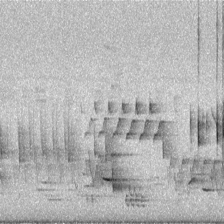

In [26]:
transformer = torchvision.transforms.ToPILImage()
transformer(first_tensor)

## Use model on prediction files

Finally, the model can be used for prediction. The model must be put into "evaluate" mode instead of training mode. This returns a long 

In [27]:
_ = model.eval()

Use OpenSoundscape's `predict` function to call the model on the test dataset. The `label_dict` created above is used to make the classes interpretable; otherwise, the classes would just be numbered.

In [28]:
prediction_df = predict(model, test_dataset, label_dict=label_dict)
prediction_df

,hylocichla-mustelina-absent,hylocichla-mustelina-present
prediction_example/split_files/1min_0s-5s.wav,2.351259,-1.628652
prediction_example/split_files/1min_5s-10s.wav,2.513747,-2.366485
prediction_example/split_files/1min_10s-15s.wav,0.816133,-0.903320
prediction_example/split_files/1min_15s-20s.wav,0.273381,-0.397208
prediction_example/split_files/1min_20s-25s.wav,1.315882,-1.407135
prediction_example/split_files/1min_25s-30s.wav,1.744635,-1.055664
prediction_example/split_files/1min_30s-35s.wav,1.940377,-1.725088
prediction_example/split_files/1min_35s-40s.wav,2.138355,-1.632506
prediction_example/split_files/1min_40s-45s.wav,1.766514,-1.096341
prediction_example/split_files/1min_45s-50s.wav,1.570931,-1.124706


Finally, this command "cleans up" by deleting all the downloaded files and results.

In [29]:
import shutil
shutil.rmtree(folder_path)